In [197]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Video, widgets
from IPython.display import display

%matplotlib inline

In [217]:
video_path = 'Chess_Data\\chess_easy1.mp4'

In [218]:
video_capture = cv2.VideoCapture(video_path)

In [219]:
def save_first_frame(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Release the video capture object
    cap.release()

    return frame

first_frame = save_first_frame(video_path)

In [220]:
def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

In [221]:
gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(gray, 50, 150)

frame_with_boxes = first_frame.copy()
dst = cv2.cornerHarris(blurred, 5, 3, 0.02)
dst = cv2.dilate(dst, None)
corners = np.argwhere(dst > 0.01 * dst.max())

# Find corners closest to image corners
image_corners = np.array([[0, 0], [0, first_frame.shape[1]], [first_frame.shape[0], 0], [first_frame.shape[0], first_frame.shape[1]]])
closest_corners = find_closest_points_to_corners(corners, image_corners)

target_square_size = 1000  # Adjust the size as needed
target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
closest_corners = np.array([[[y, x]] for x, y in closest_corners], dtype=int)

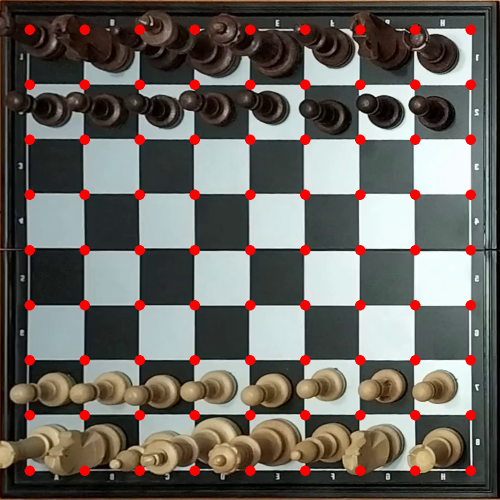

In [222]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

# Apply the perspective transformation
calibrated_image = cv2.warpPerspective(first_frame, homography_matrix, (target_square_size, target_square_size))

grid_img = calibrated_image.copy()
offset = 59 # Board edge offset
grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
# for x in grid_division:
#     cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
#     cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)
points = []  
for x in grid_division:
    for y in grid_division:
        points.append((x, y))
        cv2.circle(grid_img, (x, y), 5, (0, 0, 255), 10)

imshow(resize_img(grid_img, 2))

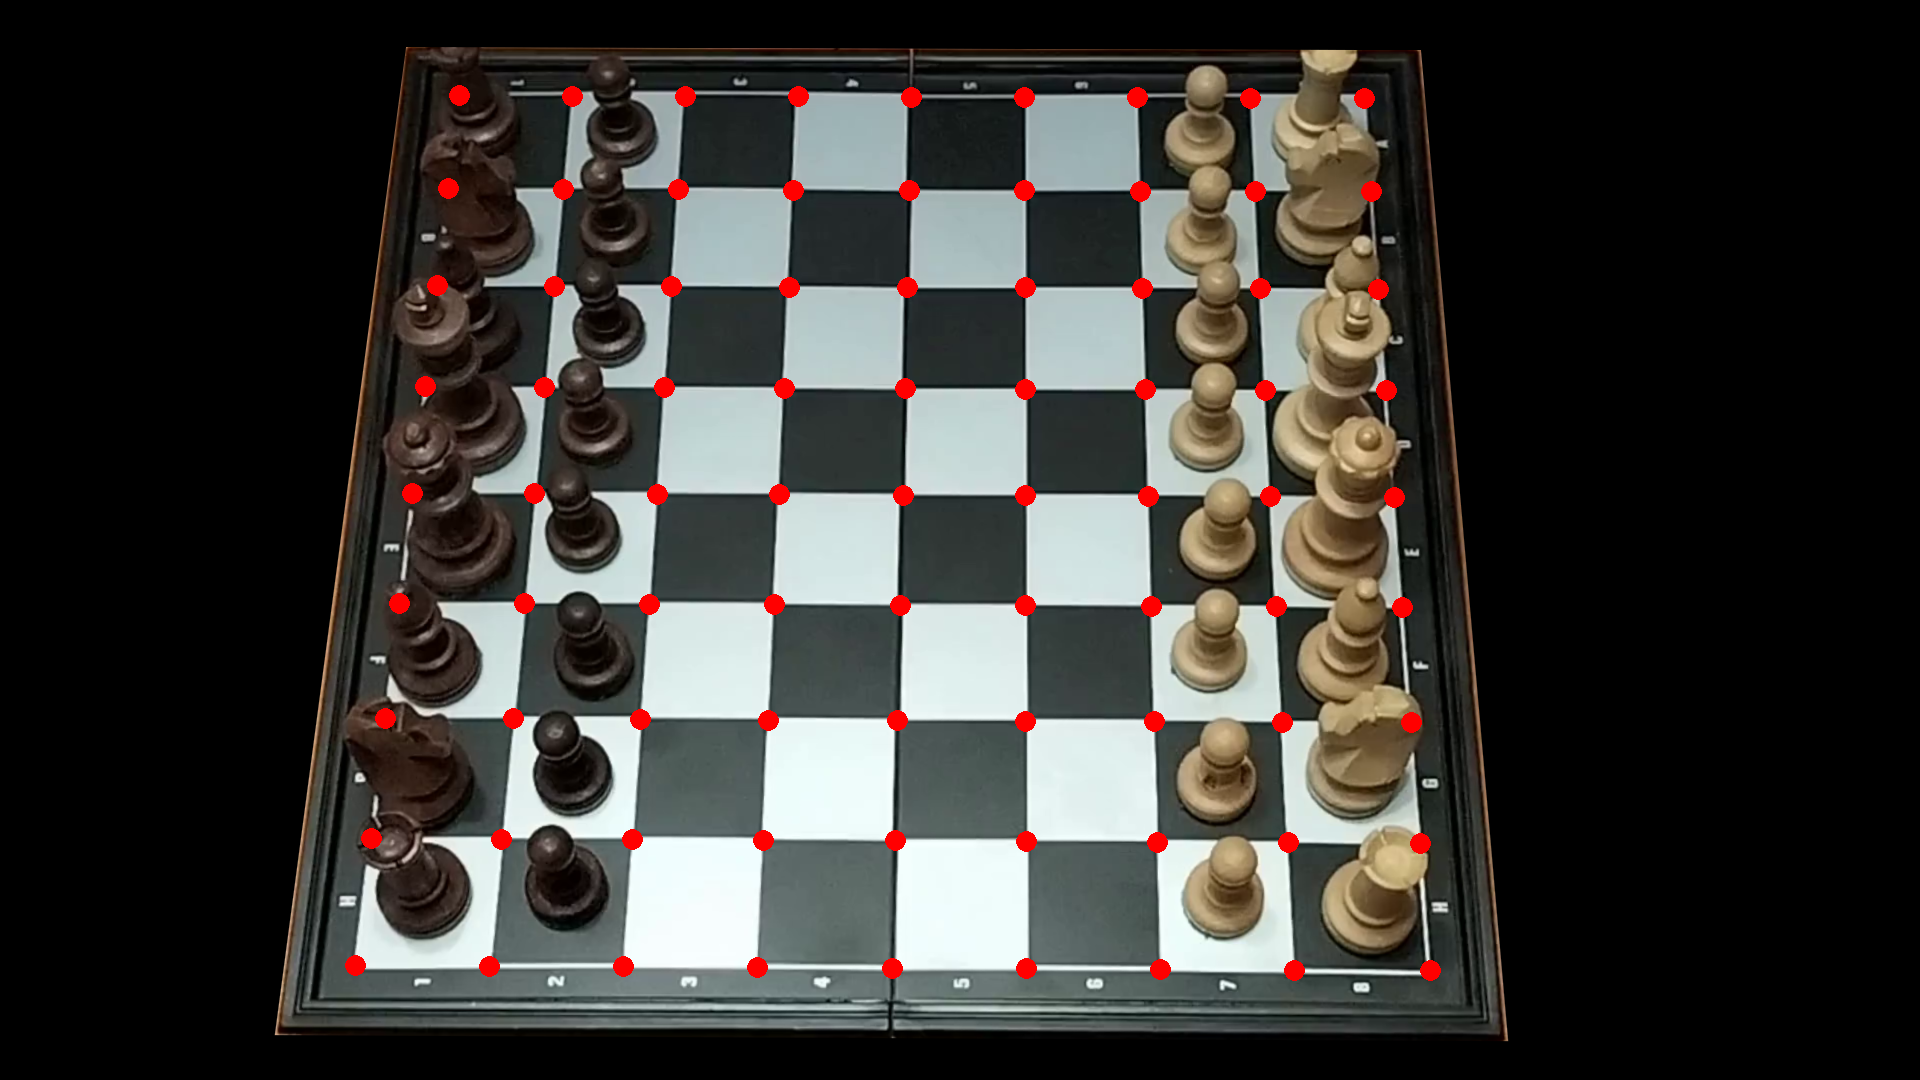

In [223]:
# Invert the homography matrix to get the reverse transformation
inverse_homography_matrix = np.linalg.inv(homography_matrix)
reverted_image = cv2.warpPerspective(calibrated_image, inverse_homography_matrix, (first_frame.shape[1], first_frame.shape[0]))

points = np.array(points, dtype=int)
calibrated_points_homogeneous = np.column_stack((points, np.ones(len(points))))
original_points_homogeneous = np.dot(inverse_homography_matrix, calibrated_points_homogeneous.T).T
original_points = original_points_homogeneous[:, :2] / original_points_homogeneous[:, 2:]

for point in original_points:
    cv2.circle(reverted_image, point.astype(int), 5, (0, 0, 255), 10)

imshow(reverted_image)

In [224]:
def create_mosse_tracker(image, point, offset=40):
    tracker = cv2.legacy.TrackerMOSSE_create()
    bbox = (point[0]-offset, point[1]-offset, 2*offset, 2*offset)
    tracker.init(image, bbox)
    return tracker, bbox

def euclidean_distance(point1, point2):
    x1, y1 = point1[:-2]
    x2, y2 = point2[:-2]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def euclidean_distance_bboxes(bboxes1, bboxes2, succesful_tracking):
    bboxes1 = np.array(bboxes1[:-2])
    bboxes2 = np.array(bboxes2[:-2])

    distances = np.linalg.norm(bboxes1 - bboxes2, axis=1)
    
    # Penalize unsuccessfully tracked points 
    distances = np.array([x if succesful_tracking[i] else 99999 for i, x in enumerate(distances)])
    return distances

def find_new_homography_matrix(prev_homography_matrix, ref_ids, current_bboxes, previous_bboxes):
    new_homography_matrix = prev_homography_matrix.copy()    
    ref_ids = set(ref_ids)
    current_points = np.array([(x[0], x[1]) for i, x in enumerate(current_bboxes) if i in ref_ids], dtype=int)
    previous_points = np.array([(x[0], x[1]) for i, x in enumerate(previous_bboxes) if i in ref_ids], dtype=int)
    perspective_change = current_points - previous_points
    # print(current_points[0], previous_points[0])

    # Update the homography matrix based on the perspective change
    new_homography_matrix[0, 2] -= np.median(perspective_change[:, 0])
    new_homography_matrix[1, 2] -= np.median(perspective_change[:, 1])
    # print(np.mean(perspective_change[:, 0]))
    return new_homography_matrix

# Poor results
# def initialize_trackers_grid(grid, trackers, frame, point_offset=40):
#     # print("i")
#     new_trackers = []
#     grid_points = [[x, y] for x in grid for y in grid]
#     bboxes = []
#     for i, point in enumerate(grid_points):
#         # bbox = (point[0]-point_offset, point[1]-point_offset, 2*point_offset, 2*point_offset)
#         # trackers[i].init(frame, bbox)
#         tracker, bbox = create_mosse_tracker(frame, point, offset=point_offset)
#         new_trackers.append(tracker)
#         bboxes.append(bbox)

#     return new_trackers, bboxes

## For original space

In [225]:
trackers = []
current_bboxes = []
point_offset = 40
for point in original_points.astype(int):
    tracker, bbox = create_mosse_tracker(first_frame, point, offset=point_offset)
    current_bboxes.append(bbox)
    trackers.append(tracker)

video_capture = cv2.VideoCapture(video_path)

ref_id_count = 15

prev_homography_matrix = homography_matrix.copy()
previous_bboxes = current_bboxes.copy()
frame_count = 0
while True:
    frame_count += 1
    # Read a new frame
    ret, frame = video_capture.read()

    # Break the loop if the video has ended
    if not ret:
        break

    current_bboxes = []
    successful_ids = [False] * len(trackers)
    # Update the MOSSE trackers
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_bboxes.append(bbox)
            successful_ids[i] = True
            # cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
            # cv2.circle(calibrated_frame, (bbox[0]+40, bbox[1]+40), 5, (0, 255, 0), 10)

        else:
            current_bboxes.append(previous_bboxes[i])
            # new_bbox = (new_x, new_y, new_width, new_height)
            # tracker = cv2.TrackerMOSSE_create()
            # tracker.init(frame, new_bbox)
    
    distances = euclidean_distance_bboxes(current_bboxes, previous_bboxes, successful_ids)
    distance_ids = [(i, distance) for i, distance in zip(range(len(trackers)), distances)]
    distance_ids.sort(key=lambda x: x[1])

    # Take x bboxes with least change into consideration !! Wrong - uses points that do not change on calibrated image instead of the original
    ref_ids = [x[0] for x in distance_ids if successful_ids[x[0]]][:-10]

    for i, bbox in enumerate(current_bboxes):
        if i in set(ref_ids):
            cv2.circle(frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 0, 255), 10)
        else:
            cv2.circle(frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 255, 0), 10)

    # Create new homography matrix based on change in least changed trackers?
    # Calibrate frame based on previous matrix
    # prev_homography_matrix = find_new_homography_matrix(prev_homography_matrix, ref_ids, current_bboxes, previous_bboxes)
    
    current_points = np.array([(x[0], x[1]) for i, x in enumerate(current_bboxes) if i in ref_ids])
    prev_points = np.array([(x[0], x[1]) for i, x in enumerate(previous_bboxes) if i in ref_ids])
    new_homography_matrix, _ = cv2.findHomography(current_points, prev_points)
    
    previous_bboxes = current_bboxes

    # calibrated_frame = cv2.warpPerspective(frame, prev_homography_matrix, (target_square_size, target_square_size))
    calibrated_frame = cv2.warpPerspective(frame, new_homography_matrix, (frame.shape[1], frame.shape[0]))

    calibrated_frame2 = cv2.warpPerspective(calibrated_frame, homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_frame2.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # if frame_count == 5*30:
    #     frame_count = 0
    #     trackers, current_bboxes = initialize_trackers_grid(grid_division, trackers, calibrated_frame, point_offset=80)

    cv2.imshow('MOSSE Tracker', grid_img)
    # cv2.imshow('MOSSE Tracker', calibrated_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

In [ ]:
trackers = []
current_bboxes = []
point_offset = 40
for point in original_points.astype(int):
    tracker, bbox = create_mosse_tracker(first_frame, point, offset=point_offset)
    current_bboxes.append(bbox)
    trackers.append(tracker)

video_capture = cv2.VideoCapture(video_path)

ref_id_count = 15

prev_homography_matrix = homography_matrix.copy()
previous_bboxes = current_bboxes.copy()
frame_count = 0
while True:
    frame_count += 1
    # Read a new frame
    ret, frame = video_capture.read()

    # Break the loop if the video has ended
    if not ret:
        break

    current_bboxes = []
    successful_ids = [False] * len(trackers)
    # Update the MOSSE trackers
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_bboxes.append(bbox)
            successful_ids[i] = True
            # cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
            # cv2.circle(calibrated_frame, (bbox[0]+40, bbox[1]+40), 5, (0, 255, 0), 10)

        else:
            current_bboxes.append(previous_bboxes[i])
            # new_bbox = (new_x, new_y, new_width, new_height)
            # tracker = cv2.TrackerMOSSE_create()
            # tracker.init(frame, new_bbox)
    
    distances = euclidean_distance_bboxes(current_bboxes, previous_bboxes, successful_ids)
    distance_ids = [(i, distance) for i, distance in zip(range(len(trackers)), distances)]
    distance_ids.sort(key=lambda x: x[1])

    # Take x bboxes with least change into consideration !! Wrong - uses points that do not change on calibrated image instead of the original
    ref_ids = [x[0] for x in distance_ids if successful_ids[x[0]]][:-20]

    for i, bbox in enumerate(current_bboxes):
        if i in set(ref_ids):
            cv2.circle(frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 0, 255), 10)
        else:
            cv2.circle(frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 255, 0), 10)

    # Create new homography matrix based on change in least changed trackers?
    # Calibrate frame based on previous matrix
    prev_homography_matrix = find_new_homography_matrix(prev_homography_matrix, ref_ids, current_bboxes, previous_bboxes)
    
    previous_bboxes = current_bboxes

    calibrated_frame = cv2.warpPerspective(frame, prev_homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_frame.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # if frame_count == 5*30:
    #     frame_count = 0
    #     trackers, current_bboxes = initialize_trackers_grid(grid_division, trackers, calibrated_frame, point_offset=80)

    cv2.imshow('MOSSE Tracker', grid_img)
    # cv2.imshow('MOSSE Tracker', calibrated_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

## For calibrated space with frame lag

In [226]:
trackers = []
current_bboxes = []
point_offset = 60
for point in points:
    tracker, bbox = create_mosse_tracker(calibrated_image, point, offset=point_offset)
    current_bboxes.append(bbox)
    trackers.append(tracker)

video_capture = cv2.VideoCapture(video_path)

ref_id_count = 15

prev_homography_matrix = homography_matrix.copy()
previous_bboxes = current_bboxes.copy()
frame_count = 0
while True:
    frame_count += 1
    # Read a new frame
    ret, frame = video_capture.read()

    # Break the loop if the video has ended
    if not ret:
        break

    # Calibrate frame based on previous matrix
    calibrated_frame = cv2.warpPerspective(frame, prev_homography_matrix, (target_square_size, target_square_size))

    current_bboxes = []
    successful_ids = [False] * len(trackers)
    # Update the MOSSE trackers
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(calibrated_frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_bboxes.append(bbox)
            successful_ids[i] = True
            # cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
            # cv2.circle(calibrated_frame, (bbox[0]+40, bbox[1]+40), 5, (0, 255, 0), 10)

        else:
            current_bboxes.append(previous_bboxes[i])
    
    distances = euclidean_distance_bboxes(current_bboxes, previous_bboxes, successful_ids)
    distance_ids = [(i, distance) for i, distance in zip(range(len(trackers)), distances)]
    distance_ids.sort(key=lambda x: x[1])

    # Take x bboxes with least change into consideration !! Wrong - uses points that do not change on calibrated image instead of the original
    ref_ids = [x[0] for x in distance_ids[:ref_id_count]]

    for i, bbox in enumerate(current_bboxes):
        if i in set(ref_ids):
            cv2.circle(calibrated_frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 0, 255), 10)
        else:
            cv2.circle(calibrated_frame, (bbox[0]+point_offset, bbox[1]+point_offset), 5, (0, 255, 0), 10)

    # Create new homography matrix based on change in least changed trackers?
    prev_homography_matrix = find_new_homography_matrix(prev_homography_matrix, ref_ids, current_bboxes, previous_bboxes)
    # previous_bboxes = current_bboxes
    grid_img = calibrated_frame.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # if frame_count == 5*30:
    #     frame_count = 0
    #     trackers, current_bboxes = initialize_trackers_grid(grid_division, trackers, calibrated_frame, point_offset=80)

    cv2.imshow('MOSSE Tracker', grid_img)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

## Tracking

In [227]:
OPENCV_OBJECT_TRACKERS = {
    "boosting": cv2.legacy.TrackerBoosting_create,
    "tld": cv2.legacy.TrackerTLD_create,
    "medianflow": cv2.legacy.TrackerMedianFlow_create,
    "mosse": cv2.legacy.TrackerMOSSE_create
}
# grab the appropriate object tracker using our dictionary of
# OpenCV object tracker objects
# tracker = OPENCV_OBJECT_TRACKERS["csrt"]()

In [ ]:
def create_mosse_tracker(image, point, point_offset=40):
    tracker = cv2.legacy.TrackerMOSSE_create()
    bbox = (point[0]-point_offset, point[1]-point_offset, 2*point_offset, 2*point_offset)
    tracker.init(image, bbox)
    return tracker, bbox

def euclidean_distance(point1, point2):
    x1, y1 = point1[:-2]
    x2, y2 = point2[:-2]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def get_relative_bbox(relative_corners, current_corners, failures, id):
    searched_corner = relative_corners[id]

    for i, corner in enumerate(relative_corners):
        if failures[i] or i == id:
            continue

        dx = searched_corner[0] - corner[0]
        dy = searched_corner[1] - corner[1]

        return (current_corners[i][0]+dx, current_corners[i][1]+dy, 80, 80)

previous_corners = current_corners.copy()
while True:
    failures = [False, False, False, False]
    # Read a new frame
    ret, frame = video_capture.read()

    # Break the loop if the video has ended
    if not ret:
        break

    # Update the MOSSE tracker
    dist_thresh = 20
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_corners[i] = bbox

            if euclidean_distance(previous_corners[i], current_corners[i]) > dist_thresh:
                failures[i] = True
        else:
            failures[i] = True
                        
    for i in range(4):
        if failures[i]:
            bbox = get_relative_bbox(previous_corners, current_corners, failures, i)
            previous_corners[i] = bbox
            trackers[i].init(frame, bbox)
        else:
            bbox = current_corners[i]
            previous_corners[i] = bbox

        center_x = bbox[0] + bbox[2] // 2
        center_y = bbox[1] + bbox[3] // 2

        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
        cv2.putText(frame, f"T{i}", (center_x-10, center_y), font, font_scale, (0, 255, 0), thickness)

    # Display the frame
    cv2.imshow('MOSSE Tracker', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

In [ ]:
video_capture = cv2.VideoCapture(video_path)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
thickness = 2

ret, frame = video_capture.read()

if not ret:
    print("Error reading video file")
    exit()

trackers = []
current_corners = []
for corner in closest_corners:
    corner = corner[0]
    tracker, bbox = create_mosse_tracker(frame, corner)
    current_corners.append(bbox)
    trackers.append(tracker)
    
previous_corners = current_corners.copy()
while True:
    failures = [False, False, False, False]
    # Read a new frame
    ret, frame = video_capture.read()

    # Break the loop if the video has ended
    if not ret:
        break

    # Update the MOSSE tracker
    dist_thresh = 20
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_corners[i] = bbox

            if euclidean_distance(previous_corners[i], current_corners[i]) > dist_thresh:
                failures[i] = True
        else:
            failures[i] = True
                        
    for i in range(4):
        if failures[i]:
            bbox = get_relative_bbox(previous_corners, current_corners, failures, i)
            previous_corners[i] = bbox
            trackers[i].init(frame, bbox)
        else:
            bbox = current_corners[i]
            previous_corners[i] = bbox

        center_x = bbox[0] + bbox[2] // 2
        center_y = bbox[1] + bbox[3] // 2

        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
        cv2.putText(frame, f"T{i}", (center_x-10, center_y), font, font_scale, (0, 255, 0), thickness)

    # Display the frame
    cv2.imshow('MOSSE Tracker', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()


intializing 1
intializing 1
fail 1
intializing 1
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intializing 0
fail 0
intial

In [ ]:
video_capture = cv2.VideoCapture(video_path)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
thickness = 2

ret, frame = video_capture.read()

if not ret:
    print("Error reading video file")
    exit()

trackers = []
# initial_corners = []
last_good_bboxes = []
for corner in closest_corners:
    corner = corner[0]
    # initial_corners.append(corner)
    tracker, bbox = create_mosse_tracker(frame, corner)
    trackers.append(tracker)
    last_good_bboxes.append(bbox)
    
frame_hist = []
hist_len = 120
while True:
    # Read a new frame
    ret, frame = video_capture.read()
    frame_hist.append(frame)
    if len(frame_hist) > hist_len:
        frame_hist.pop(0)

    # Break the loop if the video has ended
    if not ret:
        break

    # new_corners = []

    # Update the MOSSE tracker
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(frame)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            last_good_bboxes[i] = bbox
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
            
            center_x = bbox[0] + bbox[2] // 2
            center_y = bbox[1] + bbox[3] // 2
            
            cv2.putText(frame, f"T{i}", (center_x-10, center_y), font, font_scale, (0, 255, 0), thickness)

            # new_corners.append([center_x, center_y])

        else:
            print(f"Fail tracker {i}")
            for f in frame_hist:
                success, bbox = tracker.update(f)
                if success:
                    bbox = tuple(map(int, bbox))
                    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
                    break


    # initial_corners = np.array(new_corners)

    # Display the frame
    cv2.imshow('MOSSE Tracker', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
video_capture.release()
cv2.destroyAllWindows()


Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 1
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail tracker 0
Fail track

## LK tracking

In [ ]:
# # Load the video
# cap = cv2.VideoCapture(video_path)

# # Parameters for Lucas-Kanade optical flow
# lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # Read the first frame
# ret, first_frame = cap.read()
# gray_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # Calculate optical flow using Lucas-Kanade method
#     new_corners, status, _ = cv2.calcOpticalFlowPyrLK(
#         gray_first_frame, gray_frame, np.float32(closest_corners), None, **lk_params)

#     # Filter valid points
#     closest_corners = closest_corners.astype(int)
#     good_new = new_corners[status == 1]
#     good_old = closest_corners[status == 1]

#     # Draw the corners on the frame
#     for i, (new, old) in enumerate(zip(good_new, good_old)):
#         a, b = old.ravel()
#         c, d = new.ravel()
#         frame = cv2.circle(frame, (int(c), int(d)), 20, (0, 255, 0), -1)

#     # Display the frame with the corners
#     cv2.imshow('Corners Detected', frame)

#     # Break the loop if 'q' key is pressed
#     if cv2.waitKey(25) & 0xFF == ord('q'):
#         break


# # Release resources
# cap.release()
# cv2.destroyAllWindows()


## SIFT matching test

In [ ]:
# video_capture = cv2.VideoCapture(video_path)
# ret, frame = video_capture.read()
# if not ret:
#     print("Error")

# homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

# # Apply the perspective transformation
# calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))
# calibrated_image = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2GRAY)

# sift = cv2.SIFT_create()

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks = 50)
# flann = cv2.FlannBasedMatcher(index_params, search_params)

# MIN_MATCH_COUNT = 10

# while True:
#     ret, frame = video_capture.read()
#     if not ret:
#         break

#     frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     kp1, des1 = sift.detectAndCompute(calibrated_image, None)
#     kp2, des2 = sift.detectAndCompute(frame_gray, None)
    
#     matches = flann.knnMatch(des1, des2, k=2)
#     good = []
#     for m,n in matches:
#         if m.distance < 0.7*n.distance:
#             good.append(m)

#     if len(good) > MIN_MATCH_COUNT:
#         blurred = cv2.GaussianBlur(frame_gray, (5, 5), 0)
#         edges = cv2.Canny(frame_gray, 50, 150)

#         frame_with_boxes = frame.copy()
#         dst = cv2.cornerHarris(blurred, 5, 3, 0.02)
#         dst = cv2.dilate(dst, None)
#         corners = np.argwhere(dst > 0.01 * dst.max())

#         # Find corners closest to image corners
#         image_corners = np.array([[0, 0], [0, frame.shape[1]], [frame.shape[0], 0], [frame.shape[0], frame.shape[1]]])
#         closest_corners = find_closest_points_to_corners(corners, image_corners)

#         target_square_size = 1000  # Adjust the size as needed
#         target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
#         closest_corners = np.array([[[y, x]] for x, y in closest_corners], dtype=int)
#         homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

#         # Apply the perspective transformation
#         calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

#     else:
#         print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
#         matchesMask = None
    
#     # grid_img = calibrated_image.copy()
#     # offset = 59 # Board edge offset
#     # for x in np.linspace(offset, target_square_size-offset, 9, dtype=int):
#     #     cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
#     #     cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

#     # Display the result
#     # cv2.imshow('Chessboard focus', grid_img)
#     cv2.imshow('Chessboard focus', calibrated_image)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# video_capture.release()
# cv2.destroyAllWindows()

Not enough matches are found - 0/10
Not enough matches are found - 0/10
Not enough matches are found - 4/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 3/10
Not enough matches are found - 0/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 1/10
Not enough matches are found - 3/10
Not enough matches are found - 1/10


In [ ]:
# video_capture = cv2.VideoCapture(video_path)

# while True:
#     ret, frame = video_capture.read()
#     if not ret:
#         break
    
#     homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

#     # Apply the perspective transformation
#     calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

#     grid_img = calibrated_image.copy()
#     offset = 59 # Board edge offset
#     for x in np.linspace(offset, target_square_size-offset, 9, dtype=int):
#         cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
#         cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

#     # Display the result
#     cv2.imshow('Chessboard focus', grid_img)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# video_capture.release()
# cv2.destroyAllWindows()